# Exercise project 3 – CNN for time series classification (Beijing dataset)

I decided to use a weather dataset from Beijing with over 43,000 rows. It had hourly data, and I focused only on temperature and pressure.



### Step 0: Importing libraries and loading the dataset

In [ ]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_3"
os.chdir(folder_path)

In [ ]:
df = pd.read_csv("data/beijing.csv")

### Step 1: Data analysis and visualisations

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.head(5)

,no,year,month,day,hour,pm2.5,dewp,temp,pres,cbwd,iws,is,ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


I combined the individual date info columns into a single "datetime" column

In [ ]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

In [ ]:
df.head(1)

,no,year,month,day,hour,pm2.5,dewp,temp,pres,cbwd,iws,is,ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01


I cleaned the data by dropping unnecessary columns

In [ ]:
df.drop(columns=['year', 'no', 'month', 'day', 'hour', 'pm2.5', 'dewp', 'cbwd', 'iws', 'is', 'ir'], inplace=True)

In [ ]:
df.head(1)

,temp,pres,datetime
0,-11.0,1021.0,2010-01-01


here, I checked for NaNs

In [ ]:
missing_summary = df.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
temp        0
pres        0
datetime    0
dtype: int64


In [ ]:
print(df.describe())

               temp          pres             datetime
count  43824.000000  43824.000000                43824
mean      12.448521   1016.447654  2012-07-01 23:30:00
min      -19.000000    991.000000  2010-01-01 00:00:00
25%        2.000000   1008.000000  2011-04-02 11:45:00
50%       14.000000   1016.000000  2012-07-01 23:30:00
75%       23.000000   1025.000000  2013-10-01 11:15:00
max       42.000000   1046.000000  2014-12-31 23:00:00
std       12.198613     10.268698                  NaN


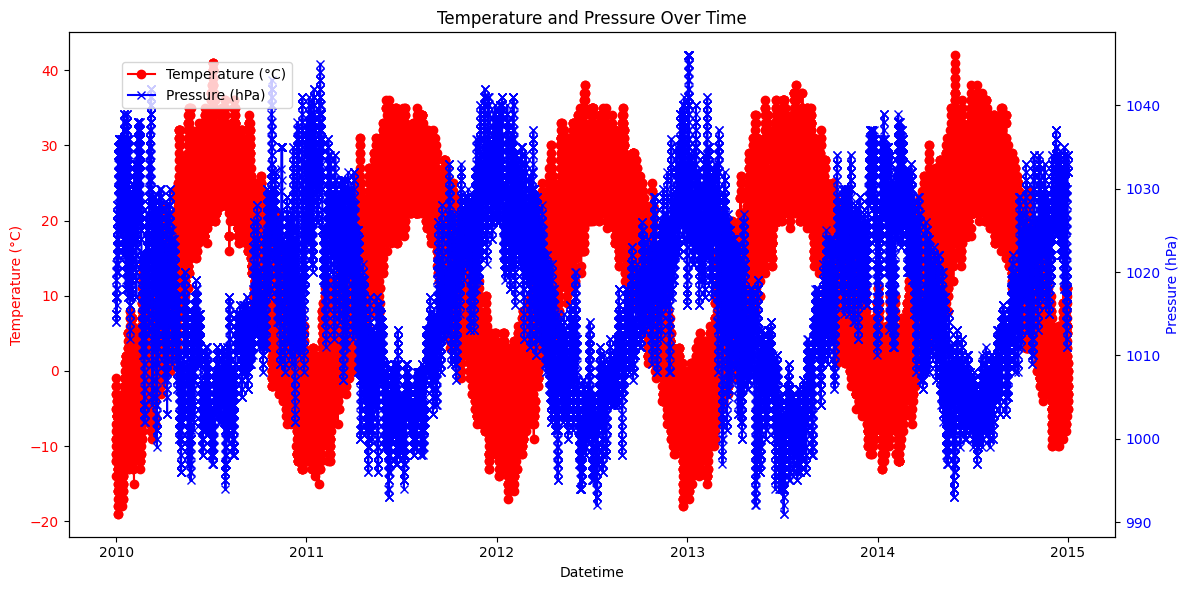

In [ ]:
# figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# left y-axis temp
ax1.plot(df['datetime'], df['temp'], color='red', label='Temperature (°C)', linestyle='-', marker='o')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(df['datetime'], df['pres'], color='blue', label='Pressure (hPa)', linestyle='-', marker='x')
ax2.set_ylabel('Pressure (hPa)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# rotate x-axis labels
plt.title('Temperature and Pressure Over Time')
plt.xticks(rotation=45)

# legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# plot
plt.tight_layout()
plt.show()

### Step 2: Data pre-processing

Then I removed the datetime column and replaced it with a numerical time sequence, since the model does not need actual dates, just the order.

In [ ]:
df['time_sequence'] = range(1, len(df) + 1)
df.drop(columns=['datetime'], inplace=True)

In [ ]:
df.head()

,temp,pres,time_sequence
0,-11.0,1021.0,1
1,-12.0,1020.0,2
2,-11.0,1019.0,3
3,-14.0,1019.0,4
4,-12.0,1018.0,5


In [ ]:
scaler = MinMaxScaler()

# numeric columns scaled
numeric_columns = ['temp', 'pres', 'time_sequence']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [ ]:
df.head()

,temp,pres,time_sequence
0,0.131148,0.545455,0.000000
1,0.114754,0.527273,0.000023
2,0.131148,0.509091,0.000046
3,0.081967,0.509091,0.000068
4,0.114754,0.490909,0.000091


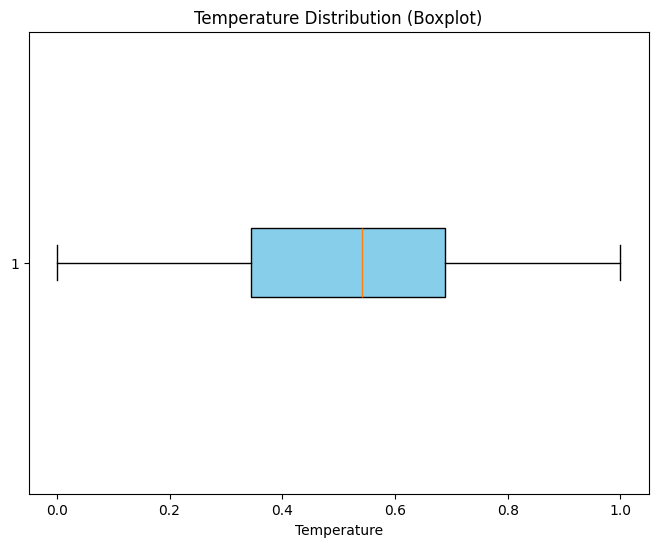

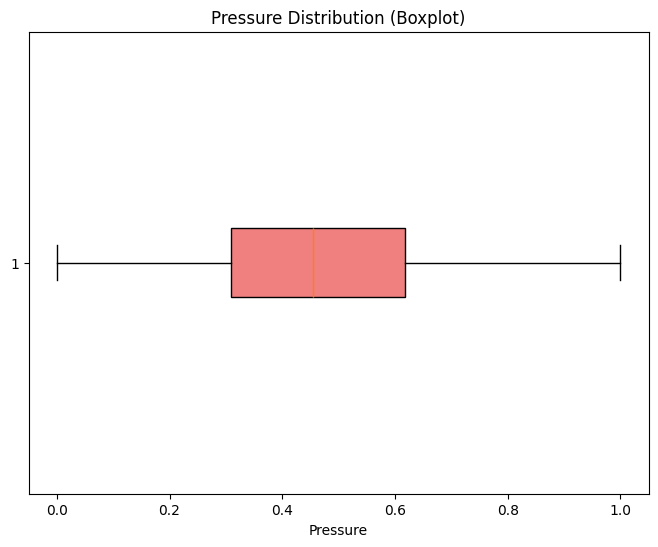

In [ ]:
# Boxplot for temperature
plt.figure(figsize=(8, 6))
plt.boxplot(df['temp'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Temperature Distribution (Boxplot)')
plt.xlabel('Temperature')
plt.show()

# Boxplot for pressure
plt.figure(figsize=(8, 6))
plt.boxplot(df['pres'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
plt.title('Pressure Distribution (Boxplot)')
plt.xlabel('Pressure')
plt.show()

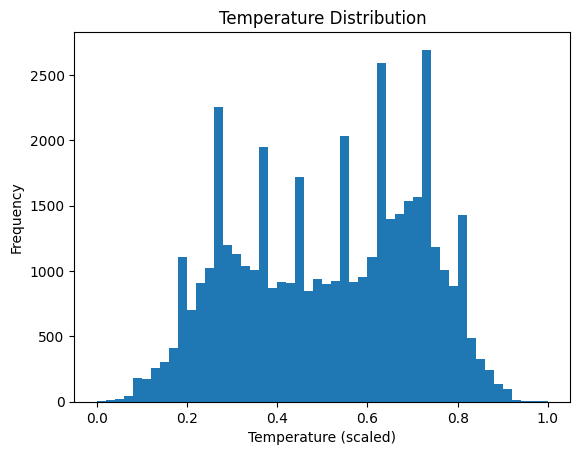

Mean: 0.515549530461639, Median: 0.5409836065573771, Std Dev: 0.19997725884707748


In [ ]:
plt.hist(df['temp'], bins=50)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (scaled)')
plt.ylabel('Frequency')
plt.show()

temp_mean = df['temp'].mean()
temp_median = df['temp'].median()
temp_std = df['temp'].std()
print(f"Mean: {temp_mean}, Median: {temp_median}, Std Dev: {temp_std}")

I split the data into timesteps of 20 points each. That means every training example became a sequence of 20 hours of temperature and pressure readings. This gave me 2,191 total samples.

In [ ]:
timestep_size = 20

In [ ]:
num_timesteps = len(df) // timestep_size
total_length = num_timesteps * timestep_size
df = df.iloc[:total_length]  # trimming the dataframe to a multiple of timestep_size

In [ ]:
features = ['temp', 'pres']
data = df[features].values

In [ ]:
data = data.reshape(num_timesteps, timestep_size, len(features))

In [ ]:
temp_threshold = df['temp'].mean()
pres_threshold = df['pres'].mean()

I created labels for each timestep based on the average temp and pressure.

In [ ]:
labels = []

for i in range(num_timesteps):
    timestep_data = data[i]
    mean_temp = timestep_data[:, 0].mean()  # Index 0 corresponds to 'temp'
    mean_pres = timestep_data[:, 1].mean()  # Index 1 corresponds to 'pres'

    # Example labeling logic:
    if mean_temp > temp_threshold and mean_pres <= pres_threshold:
        labels.append(0)  # Class 0: High temp, normal pres
    elif mean_temp <= temp_threshold and mean_pres > pres_threshold:
        labels.append(1)  # Class 1: Normal temp, high pres
    elif mean_temp > temp_threshold and mean_pres > pres_threshold:
        labels.append(2)  # Class 2: High temp, high pres
    else:
        labels.append(3)  # Class 3: Normal temp, normal pres

labels = np.array(labels)

I encoded the classses

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))
print("Label distribution:", label_counts)

Label distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(898), np.int64(2): np.int64(172), np.int64(3): np.int64(121)}


I plotted this distribution to check that there were enough samples for each class, which there was not in Classes 2-3.

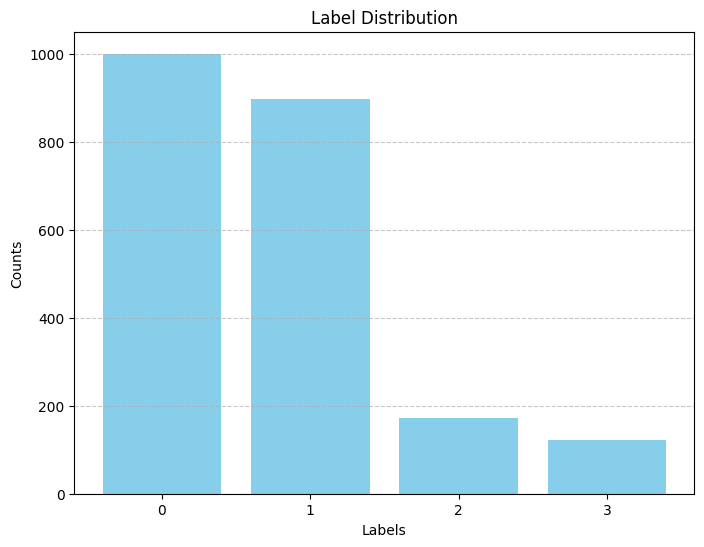

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
train_size = int(num_timesteps * 0.75)

X_train = data[:train_size]
y_train = labels[:train_size]

X_test = data[train_size:]
y_test = labels[train_size:]

### Step 3: Model Architecture

In [ ]:
num_classes = len(np.unique(labels))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

I built a simple 1D Convolutional Neural Network (CNN). I added one Conv1D layer with 64 filters, followed by MaxPooling1D, then Flatten, and two dense layers. The final layer had 4 outputs with softmax, since I had 4 classes.

In [ ]:
model = Sequential()
model.add(InputLayer(shape=(timestep_size, len(features))))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Use 'sigmoid' for binary classification

I trained the model for 20 epochs, using class weights to help with the imbalance a little bit.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train_cat, epochs=20, validation_data=(X_test, y_test_cat), class_weight=class_weights_dict)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7024 - loss: 1.1414 - val_accuracy: 0.7482 - val_loss: 0.5349
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8333 - loss: 0.6580 - val_accuracy: 0.8449 - val_loss: 0.4186
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8616 - loss: 0.5886 - val_accuracy: 0.7883 - val_loss: 0.4466
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8507 - loss: 0.5631 - val_accuracy: 0.8540 - val_loss: 0.3689
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8834 - loss: 0.4647 - val_accuracy: 0.8650 - val_loss: 0.4114
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8884 - loss: 0.4813 - val_accuracy: 0.8777 - val_loss: 0.3463
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9023 - loss: 0.3816 - val_accuracy: 0.8412 - val_loss: 0.3920
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9046 - loss: 0.3178 - val_accuracy: 0.9124 - val_loss

### Step 4: Model Evaluation

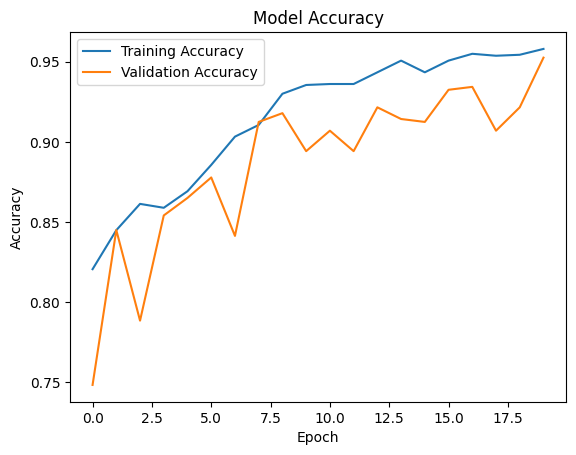

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

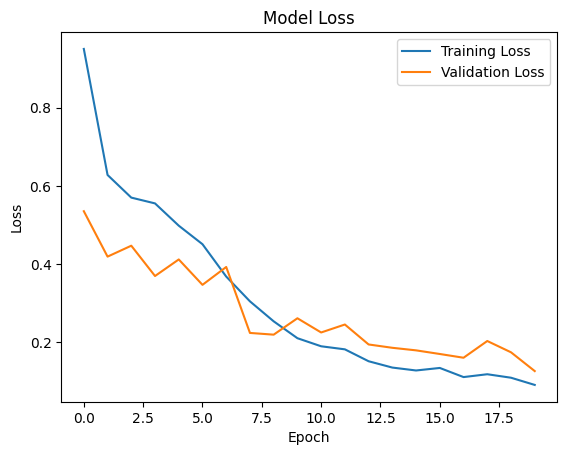

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f'Test Accuracy: {test_accuracy:.4f}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 0.1508 
Test Accuracy: 0.9526


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Confusion matrix showed only a few misclassifications

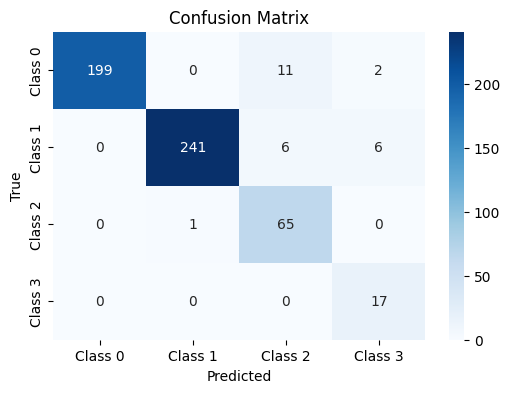

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ["Class 0", "Class 1", "Class 2", "Class 3"]

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       212
           1       1.00      0.95      0.97       253
           2       0.79      0.98      0.88        66
           3       0.68      1.00      0.81        17

    accuracy                           0.95       548
   macro avg       0.87      0.97      0.91       548
weighted avg       0.96      0.95      0.96       548



In [ ]:
# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro')
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.9986


### Step 5: Predictions

In [ ]:
# Generate random data within the scaled range [0, 1]
synthetic_signal = np.random.rand(timestep_size, len(features))
synthetic_signal = synthetic_signal.reshape(1, timestep_size, len(features))

In [ ]:
synthetic_pred_prob = model.predict(synthetic_signal)
synthetic_pred_class = np.argmax(synthetic_pred_prob, axis=1)
print(f'Predicted class for synthetic signal: {synthetic_pred_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Predicted class for synthetic signal: 3


Finally, I wanted to test the model on a completely new signal that I made myself. I asked ChatGPT: "generate a fake signal resembling a high temp, normal pressure pattern".

With that help, I made a fake signal with 20 steps. The temperature values were high (between 0.75 and 0.95) and the pressure values were in the normal range (between 0.4 and 0.6). I gave this signal to the model, and it predicted Class 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


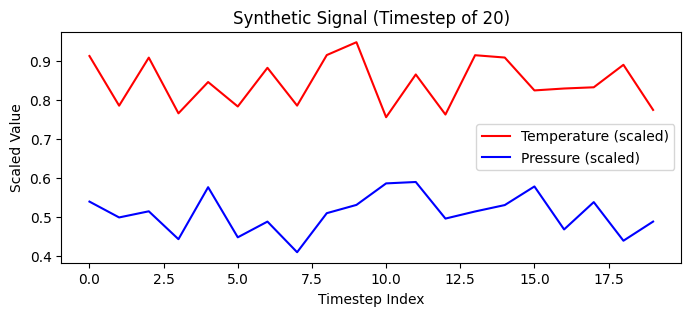

Predicted class for synthetic signal: 0
Class probabilities: [[5.73301971e-01 1.19469945e-08 4.26697701e-01 3.24929744e-07]]


In [ ]:
# synthetic signal resembling a high temp, normal pressure pattern
# values are in scaled range [0, 1]
fake_temp = np.random.uniform(0.75, 0.95, size=20)  # High temperature
fake_pres = np.random.uniform(0.4, 0.6, size=20)    # Normal pressure
fake_signal = np.stack((fake_temp, fake_pres), axis=1)

# Reshape for model input
fake_signal_input = np.expand_dims(fake_signal, axis=0)

# Predict the class
prediction = model.predict(fake_signal_input)
predicted_class = np.argmax(prediction)

# Visualize the fake signal
plt.figure(figsize=(8, 3))
plt.plot(fake_temp, label="Temperature (scaled)", color="red")
plt.plot(fake_pres, label="Pressure (scaled)", color="blue")
plt.title("Synthetic Signal (Timestep of 20)")
plt.xlabel("Timestep Index")
plt.ylabel("Scaled Value")
plt.legend()
plt.show()

# prediction
print("Predicted class for synthetic signal:", predicted_class)
print("Class probabilities:", prediction)

### Personal Analysis / Refelection

In this project, I used a dataset with 43,824 rows of hourly Beijing weather data. I focused only on temperature and pressure, scaled them using MinMaxScaler, and split the signal into timesteps of 20 points each, giving me 2,191 samples.

I created 4 classes based on whether temperature and pressure were above or below average.

Class 0 (high temp, normal pressure): 1000

Class 1 (normal temp, high pressure): 898

Class 2 (high temp, high pressure): 172

Class 3 (normal temp, normal pressure): 121

I trained a CNN with a Conv1D layer (64 filters), max pooling, and dense layers. The model trained for 20 epochs. It proved to be almost 95% accurate.

Class 2 had F1-score of 0.89, and even Class 3, with only 17 samples, had a recall of 1.00


This model worked surprisingly well even with just two features. I think this kind of signal classification could be really useful for weather trend analysis, detecting sensor anomalies, or even climate monitoring.